# Causal inference

Let's consider the following Causal Bayesian network from Pearl's, _Causality_

![](Figures/sprinklers.png)

and make some synthetic data for it

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import systyle as sty
from scipy.stats import fisher_exact

In [2]:
nObservations = 5000

In [3]:
np.random.seed(1)

Let the season be a random integer

- 0 = spring
- 1 = summer
- 2 = autumn
- 3 = winter

In [4]:
seasonNames = ['spring', 'summer', 'autumn', 'winter']

In [5]:
season = np.random.randint(4, size=nObservations)

In [6]:
probabilityOfRain = [0.3, 0.05, 0.5, 0.6]  # for the 4 seasons

In [7]:
rain = np.array([1 if np.random.uniform() < probabilityOfRain[s] else 0 for s in season])

In [8]:
probabilityOfSprinkler = [0.3, 0.7, 0.1, 0.0]

In [9]:
sprinkler = np.array([1 if np.random.uniform() < probabilityOfSprinkler[s] else 0 for s in season])

In [10]:
wet = np.array([1 if (sprinkler[i]==1 or rain[i]==1) else 0 for i in range(nObservations)])

In [11]:
probabilityOfSlippery = 0.3

In [12]:
slippery = np.array([1 if ((np.random.uniform() < probabilityOfSlippery) and (w==1)) else 0 for w in wet])

In [13]:
observations = pd.DataFrame(data=np.vstack((season, rain, sprinkler, wet, slippery)).T, 
                            columns=['season', 'rain', 'sprinkler', 'wet', 'slippery'])

In [14]:
observations

,season,rain,sprinkler,wet,slippery
0,1,0,0,0,0
1,3,1,0,1,1
2,0,0,0,0,0
3,0,0,0,0,0
4,3,0,0,0,0
...,...,...,...,...,...
4995,0,1,1,1,0
4996,3,1,0,1,0
4997,0,0,1,1,0
4998,3,1,0,1,0


## Investigating spurious correlations

To begin with, let's investigate the joint distribution of $P(X_3, X_2)$

In [15]:
def annotateCounts(ax, contingency, deltaX = 0.1, color='red', fontsize=15):
    for i in range(contingency.shape[0]):
        for j in range(contingency.shape[1]):
            ax.annotate(str(contingency.loc[i,j]), [i-deltaX,j], color=color, fontsize=fontsize)

In [16]:
jitterNoise = lambda a, o: np.random.uniform(-a, a, size=o)

In [17]:
contingencySprinklerRain = pd.crosstab(observations.sprinkler, observations.rain) 

In [18]:
contingencySprinklerRain

rain,0,1
sprinkler,,
0,2005,1611
1,1167,217


Text(0, 0.5, 'Rain')

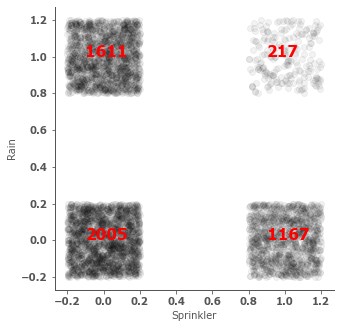

In [19]:
fig, ax = sty.plot()
ax.plot(observations.sprinkler + jitterNoise(0.2, nObservations), 
        observations.rain + jitterNoise(0.2, nObservations), 
        'ok', alpha=0.05)
annotateCounts(ax, contingencySprinklerRain)
ax.set_xlabel('Sprinkler')
ax.set_ylabel('Rain')

We see that there is some correlation between the two variables -- knowing one of the variables (e.g. $X_3 == 0$)  tells you something about the other variable ($X_2$ is probably 1). This is because the two variables in the DAG have a common parent -- the season, and as a result the children share dependency. 

Let's do a frequentist hypothesis test, to double-check

In [20]:
contingencySprinklerRain

rain,0,1
sprinkler,,
0,2005,1611
1,1167,217


In [21]:
o, p, = fisher_exact(contingencySprinklerRain.values)
p

2.4174791352130407e-87

Now, if we control for the season, by setting $X_1=x_1$, then $X_3$ and $X_2$ become independent -- in other words $X_2 \bot X_3 | X_1$. So we do not expect to be able to learn anything about whether it's raining, given the state of the sprinkler, if the season is fixed to some value (e.g. summer).

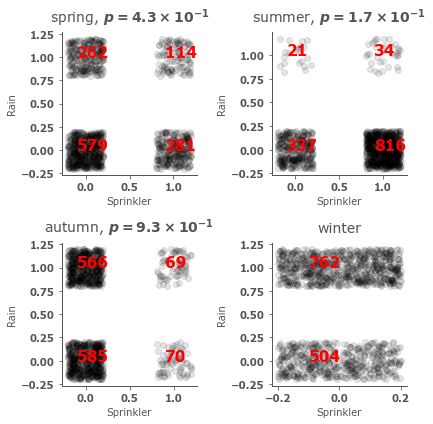

In [22]:
observationsSpring = observations[observations.season == 0]

fig, axs = sty.plot(n_rows=2, n_cols=2, fig_size=3)

for i, ax in enumerate(axs):
    observationsSeason = observations[observations.season == i]
    ax.plot(observationsSeason.sprinkler + jitterNoise(0.2, observationsSeason.shape[0]), 
            observationsSeason.rain + jitterNoise(0.2, observationsSeason.shape[0]), 
            'ok', alpha=0.1)
    ax.set_xlabel('Sprinkler')
    ax.set_ylabel('Rain')
    contingency = pd.crosstab(observationsSeason.sprinkler, observationsSeason.rain) 
    annotateCounts(ax, contingency)
    if contingency.shape[0] == 2 and contingency.shape[1] == 2:
        o, p, = fisher_exact(contingency.values)
        ax.set_title(seasonNames[i]+', $p={}$'.format(sty.to_latex(p)))
    else:
        ax.set_title(seasonNames[i])
plt.tight_layout()

So we see a bunch of insignificant p-values, as we expect (NB: I ought to do multiple hypothesis correction here, but this is just demonstrative).

**Now comes the interesting part**. **If we condition on $X_4$, we will induce a spurious correlation between $X_3$ and $X_2$**. This is because $X_3$ and $X_2$ are related to $X_4$ through a collider vertex. 

The intuition is, if the pavement is wet, it was either caused by the sprinkler being on or it was raining. If we know that the sprinkler is on, then it probably wasn't raining. If we know the sprinkler was off, then in this deterministic example, it was definitely because of the rain.

In [23]:
observationsWet = observations[observations.wet == 1]

Text(0, 0.5, 'Rain is on | wet')

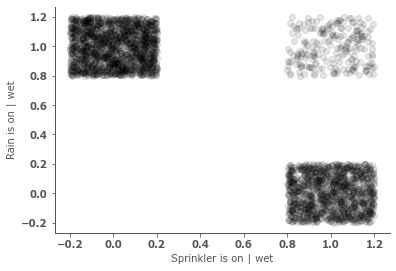

In [24]:
fig, ax = plt.subplots(1,1)
ax.plot(observationsWet.sprinkler + jitterNoise(0.2, observationsWet.shape[0]), 
        observationsWet.rain + jitterNoise(0.2, observationsWet.shape[0]), 
        'ok', alpha=0.1)
ax.set_xlabel('Sprinkler is on | wet')
ax.set_ylabel('Rain is on | wet')